The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


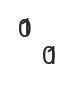

In [26]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS, get_aa_properties
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump, get_palette
from src.bootstrap import bootstrap_eval, get_pval, plot_pval
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
mpl.rcParams['figure.dpi'] = 180

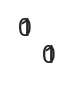

In [27]:
sns.set_palette(NEWPAL)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

In [28]:
FIGDIR = '../../../writing/230131_cedar_paper_1/figures/'

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve
def get_roc_curve_auc(df, targetcol, scorecol, neg=False):
    if neg:
        fpr, tpr, _ = roc_curve(df[targetcol], -1* df[scorecol])
        auc = roc_auc_score(df[targetcol], -1* df[scorecol])
        auc01 = roc_auc_score(df[targetcol], -1* df[scorecol], max_fpr=0.1)
    else:
        fpr, tpr, _ = roc_curve(df[targetcol], df[scorecol])
        auc = roc_auc_score(df[targetcol], df[scorecol])
        auc01 = roc_auc_score(df[targetcol], df[scorecol], max_fpr=0.1)
    return fpr, tpr, auc, auc01

# init

## reloading datasets

In [30]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221119_prime_related_10fold.csv')
ibel = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')
# merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')
nepdb = pd.read_csv('../data/mutant/230124_nepdb_filtered_scored.csv')
nepdb.head()

,Peptide,wild_type,HLA,agg_label,mut_len,wt_len,seq_id,Pos_mut,Peptide_mut,core_mut,...,core_blsm_mut_score,aliphatic_index,boman,hydrophobicity,isoelectric_point,VHSE1,VHSE3,VHSE7,VHSE8,trueHLA_EL_rank
0,AFGSAHLFR,AFGSAHLYR,HLA-A3101,1,9,9,seq_1,0,AFGSAHLFR,AFGSAHLFR,...,3,65.555556,0.837778,0.455556,10.551759,0.214444,-0.278889,0.193333,-0.192222,0.2470
1,AIANRIKFK,AIANRIKSK,HLA-A1101,0,9,9,seq_4,0,AIANRIKFK,AIANRIKFK,...,-2,108.888889,1.802222,-0.044444,11.823055,-0.048889,0.125556,0.484444,-0.125556,0.1380
2,AICKPLHYV,AICKPLHYM,HLA-A0201,0,9,9,seq_5,0,AICKPLHYV,AICKPLHYV,...,1,130.000000,-0.735556,0.755556,8.530526,0.327778,0.046667,-0.017778,0.263333,0.3610
3,AIPAMVVPNV,AIPAMVVPNA,HLA-A0201,0,10,10,seq_6,0,AIPAMVVPNV,AIPAVVPNV,...,0,146.000000,-1.637000,1.590000,6.100000,0.431000,-0.385000,-0.067000,0.446000,2.2606
4,ALEVLQSIPY,APEVLQSIPY,HLA-A0101,0,10,10,seq_7,0,ALEVLQSIPY,ALEVLQSIY,...,-3,156.000000,-0.472000,0.740000,3.849983,0.292000,-0.062000,-0.096000,0.088000,0.6230


In [31]:
cedar_aligned = pd.read_csv('../data/aligned_icore/230125_cedar_aligned_icore.csv')
prime_aligned = pd.read_csv('../data/aligned_icore/230125_prime_aligned_icore.csv')
ibel_aligned = pd.read_csv('../data/aligned_icore/230125_ibel_aligned_icore.csv')
nepdb_aligned = pd.read_csv('../data/aligned_icore/230125_nepdb_aligned_icore.csv')

In [32]:
cedar_expr = pd.read_csv('../data/pepx/230125_cedar_related_pepx_fold.csv')
prime_expr = pd.read_csv('../data/pepx/230125_prime_related_pepx.csv')
ibel_expr = pd.read_csv('../data/pepx/230125_ibel_normal_pepx.csv')
nepdb_expr = pd.read_csv('../data/pepx/230125_nepdb_normal_pepx.csv')

In [33]:
cedar_aligned_expr = pd.read_csv('../data/pepx/230308_cedar_aligned_pepx_fold.csv')
prime_aligned_expr = pd.read_csv('../data/pepx/230308_prime_aligned_pepx.csv')
ibel_aligned_expr = pd.read_csv('../data/pepx/230125_ibel_aligned_pepx.csv')
nepdb_aligned_expr = pd.read_csv('../data/pepx/230308_nepdb_aligned_pepx.csv')

In [34]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

# redo conditions

In [ ]:
cdt_base = (dict(max_len=12, encoding='onehot', blosum_matrix=None, mask=False, 
                       add_rank=True, seq_col='Peptide', rank_col='trueHLA_EL_rank', hla_col='HLA',
                       target_col = 'agg_label', add_aaprop=False, remove_pep=False, standardize=True),
            None, 'Base')
cdt_cedar = (dict(max_len=12, encoding='onehot', blosum_matrix='None', add_rank=True, seq_col='icore_mut', rank_col='EL_rank_mut', target_col ='agg_label', hla_col='HLA',
                        add_aaprop=False, remove_pep=False, standardize=True,
                        mask=False, invert=True,
                        mut_col = aa_cols+['EL_rank_wt_aligned','icore_dissimilarity_score','ratio_rank','Total_Gene_TPM']
                        ), # Here it should be icore similarity score because it's not dissimilarity that we have
            ics_shannon, 'OptCEDAR')

cdt_prime = (dict(max_len=12, encoding='onehot', blosum_matrix='None', add_rank=True, seq_col='icore_mut', rank_col='EL_rank_mut', target_col ='agg_label', hla_col='HLA',
                        add_aaprop=False, remove_pep=False, standardize=True,
                        mask=True, invert=False,
                        mut_col = ['icore_dissimilarity_score', 'icore_blsm_mut_score']),
            ics_shannon, 'OptPRIME')

cdt_general = (dict(max_len=12, encoding='onehot', blosum_matrix='None', add_rank=True, seq_col='icore_mut', rank_col='EL_rank_mut', target_col ='agg_label', hla_col='HLA',
                          add_aaprop=False, remove_pep=False, standardize=True,
                          mask=False, invert=False,
                          mut_col = ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'ratio_rank', 'Total_Gene_TPM']),
             None, 'General')

In [ ]:
for condition in ['Base', 'Gen', 'CEDAR', 'PRIME']:
    for add_expression in [False, True]:
        mut_cols = encoding_kwargs['mut_col'] if (condition!='Base' or add_expression)
        print(condition, mut_cols)

In [ ]:
from copy import deepcopy
encoding_kwargs = dict(max_len=12, encoding='onehot', rank_col='EL_rank_mut', seq_col='icore_mut',
                       blosum_matrix=None, mask=False, add_rank=True, add_aaprop=False, 
                       remove_pep=False, standardize=True)

# weighting : Inv Shannon, None, Mask
# weighting tuple order : (Invert, ic name, ic dict, mask)
weighting = [(True, 'Shannon', ics_shannon, False), 
             (False, 'None', None, False), 
             (False, 'Mask', ics_shannon, True)]

# find from list of raws which conditions are not here and run them...
mcs_out = deepcopy(mcs)
# stupid filter
filtered = filter(lambda x: 'onehot' in x and 'featimp' in x and 'Inverted-KL'in x, os.listdir('../output/230308_aligned_exprscore_addwtrank_foreignness/raw'))
filtered = [x.split('EL_rank_mut_')[1].replace('.csv','') for x in filtered]
mcs2 = [x for x in mcs_out if '-'.join(x) not in filtered]
len(mcs2), mcs2[:5]

(150,
 [[],
  ['EL_rank_wt_aligned', 'ratio_rank'],
  ['EL_rank_wt_aligned', 'ratio_rank', 'foreignness_score'],
  ['icore_blsm_mut_score', 'EL_rank_wt_aligned', 'ratio_rank'],
  ['icore_blsm_mut_score',
   'EL_rank_wt_aligned',
   'ratio_rank',
   'foreignness_score']])

In [ ]:
encoding_kwargs = dict(max_len=12, encoding='onehot', rank_col='EL_rank_mut', seq_col='icore_mut',
                       blosum_matrix=None, mask=False, add_rank=True, add_aaprop=False, 
                       remove_pep=False, standardize=True)

def final_bootstrap_wrapper(preds_df, filename,
                            ic_name, key, evalset,
                            n_rounds=10000, n_jobs=8):
    scores = preds_df.pred.values if 'pred' in preds_df.columns else preds_df['mean_pred'].values
    targets = preds_df.agg_label.values if 'agg_label' in preds_df.columns else preds_df['Immunogenicity'].values

    bootstrapped_df, mean_rocs = bootstrap_eval(y_score=scores,
                                                y_true=targets,
                                                n_rounds=n_rounds, n_jobs=n_jobs)
    bootstrapped_df['encoding'] = 'onehot'
    bootstrapped_df['weight'] = ic_name
    bootstrapped_df['pep_col'] = 'icore_mut'
    bootstrapped_df['rank_col'] = 'EL_rank_mut'
    bootstrapped_df['key'] = key
    bootstrapped_df['evalset'] = evalset.upper()

    bootstrapped_df.to_csv(
        f'{outdir}bootstrapping/{evalset}_bootstrapped_df_{filename}.csv',
        index=False)
    pkl_dump(mean_rocs,
             f'{outdir}bootstrapping/{evalset}_mean_rocs_{filename}.pkl')

    return bootstrapped_df

In [71]:
mcs = ['aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned'.split('-')]
mcs.append('icore_dissimilarity_score-icore_blsm_mut_score-ratio_rank-foreignness_score'.split('-'))

tpm_cols = ['Total_Peptide_TPM', 'Total_Scaled_Peptide_TPM', 'Total_Gene_TPM']
mcs.extend([x+[b] for x in mcs for b in tpm_cols])

mcs2 = []
mcs2.extend(
    [aa_cols + ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'EL_rank_wt_aligned', 'ratio_rank']])
mcs2.extend([aa_cols + ['icore_dissimilarity_score', 'icore_mut_score', 'EL_rank_wt_aligned', 'ratio_rank']])
mcs2.extend([aa_cols + ['icore_dissimilarity_score', 'EL_rank_wt_aligned', 'ratio_rank']])
mcs2.extend([aa_cols + ['icore_blsm_mut_score', 'EL_rank_wt_aligned', 'ratio_rank']])
mcs2.extend([aa_cols + ['icore_mut_score', 'EL_rank_wt_aligned', 'ratio_rank']])

mcs2.extend([aa_cols + ['icore_dissimilarity_score', 'icore_blsm_mut_score', "foreignness_score"]])
mcs2.extend([aa_cols + ['icore_dissimilarity_score', 'icore_mut_score', "foreignness_score"]])
mcs2.extend([aa_cols + ['icore_dissimilarity_score', "foreignness_score"]])
mcs2.extend([aa_cols + ['icore_blsm_mut_score', "foreignness_score"]])
mcs2.extend([aa_cols + ['icore_mut_score', "foreignness_score"]])
mcs2.extend([x+[b] for x in mcs2 for b in tpm_cols])

print(len(mcs), len(mcs2))
mcs = mcs + mcs2
len(mcs)

8 40


48

In [ ]:
# Best CEDAR, best PRIME, General Model
best_keys = [['aliphatic_index', 'boman', 'hydrophobicity', 'isoelectric_point', 'VHSE1', 'VHSE3', 'VHSE7', 'VHSE8', 'icore_dissimilarity_score', 'ratio_rank', 'EL_rank_wt_aligned'],
             ['

In [74]:
mcs = [['aliphatic_index',
  'boman',
  'hydrophobicity',
  'isoelectric_point',
  'VHSE1',
  'VHSE3',
  'VHSE7',
  'VHSE8',
  'icore_dissimilarity_score',
  'ratio_rank',
  'EL_rank_wt_aligned',
  'Total_Peptide_TPM'],
 ['aliphatic_index',
  'boman',
  'hydrophobicity',
  'isoelectric_point',
  'VHSE1',
  'VHSE3',
  'VHSE7',
  'VHSE8',
  'icore_dissimilarity_score',
  'ratio_rank',
  'EL_rank_wt_aligned',
  'Total_Scaled_Peptide_TPM'],
 ['aliphatic_index',
  'boman',
  'hydrophobicity',
  'isoelectric_point',
  'VHSE1',
  'VHSE3',
  'VHSE7',
  'VHSE8',
  'icore_dissimilarity_score',
  'ratio_rank',
  'EL_rank_wt_aligned',
  'Total_Gene_TPM']]

In [75]:
from src.utils import mkdirs, pkl_dump
from sklearn.ensemble import RandomForestClassifier
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
from src.metrics import get_nested_feature_importance

outdir = '../output/230327_fixing_exprscore_filt/'
mkdirs(outdir)
mkdirs(outdir+'raw/')
mkdirs(outdir+'bootstrapping/')

cedar_dataset = cedar_aligned_expr
prime_dataset = prime_aligned_expr
nepdb_dataset = nepdb_aligned_expr

train_dataset = cedar_dataset

mega_df = pd.DataFrame()
print('Starting loops')

for mut_cols in tqdm(mcs, position=0, leave=True, desc='cols'):
    key = '-'.join(mut_cols)
    if key == '':
        key = 'only_rank'

    key.replace('aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8',
                'aa_props')
    key.replace(' ', '-')
    encoding_kwargs['mut_col'] = mut_cols
    # megaloops for encoding-weighting
    for encoding, blosum_matrix, blsm_name in tqdm(zip(['onehot'],
                                                       [None],
                                                       ['onehot']),
                                                   desc='encoding', leave=False, position=1):
        encoding_kwargs['encoding'] = encoding
        encoding_kwargs['blosum_matrix'] = blosum_matrix

        for invert, ic_name, ics_dict, mask in [(True, 'Shannon', ics_shannon, False),
                                          (False, 'None', None, False),
                                          (False, 'Mask', ics_shannon, True)]:
            encoding_kwargs['invert'] = invert
            encoding_kwargs['mask'] = mask
            if invert:
                if ic_name == 'None':
                    continue
                else:
                    ic_name = 'Inverted ' + ic_name


            filename = f'onehot_{"-".join(ic_name.split(" "))}_icore_mut_EL_rank_mut_{key}'
            # Using the same model and hyperparameters
            model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                           max_depth=8, ccp_alpha=9.945e-6)
            # Training model and getting feature importances
            print('Training')
            trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model,
                                                                        ics_dict=ics_dict,
                                                                        encoding_kwargs=encoding_kwargs,
                                                                        n_jobs=8)
            fi = get_nested_feature_importance(trained_models)
            fn = AA_KEYS + ['rank'] + mut_cols
            # Saving Feature importances as dataframe
            df_fi = pd.DataFrame(fi, index=fn).T
            df_fi.to_csv(
                f'{outdir}raw/featimps_{filename}.csv',
                index=False)

            for evalset, evalname in zip([cedar_dataset, prime_dataset, nepdb_dataset],
                                         ['CEDAR', 'PRIME', 'NEPDB']):
                # FULLY FILTERED + Mean_pred
                if not evalset.equals(train_dataset):
                    evalset = evalset.query('Peptide not in @train_dataset.Peptide.values')
                _, preds = evaluate_trained_models_sklearn(evalset.drop_duplicates(subset=['Peptide','HLA','agg_label']),
                                                           trained_models, ics_dict,
                                                           train_dataset,
                                                           encoding_kwargs, concatenated=False,
                                                           only_concat=True, n_jobs=20)
                # p_col = 'pred' if 'pred' in preds.columns else 'mean_pred'
                preds.to_csv(f'{outdir}raw/{evalname}_preds_{filename}.csv', index=False, columns = ['Peptide', 'icore_mut', 'EL_rank_mut', 'EL_rank_wt_aligned', 'ratio_rank', 'foreignness_score', 'agg_label', 'HLA'])

                bootstrapped_df = final_bootstrap_wrapper(preds, filename, ic_name,
                                                          key, evalname, n_rounds=10000, n_jobs = 8)
            del trained_models, bootstrapped_df

Starting loops


cols:   0%|          | 0/3 [00:00<?, ?it/s]

encoding: 0it [00:00, ?it/s]

Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/CEDAR_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Peptide_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/PRIME_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Peptide_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/NEPDB_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Peptide_TPM.pkl saved.
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/CEDAR_mean_rocs_onehot_None_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Peptide_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/PRIME_mean_rocs_onehot_None_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Peptide_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/NEPDB_mean_rocs_onehot_None_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Peptide_TPM.pkl saved.
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/CEDAR_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Peptide_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/PRIME_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Peptide_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/NEPDB_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Peptide_TPM.pkl saved.


encoding: 0it [00:00, ?it/s]

Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/CEDAR_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Scaled_Peptide_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/PRIME_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Scaled_Peptide_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/NEPDB_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Scaled_Peptide_TPM.pkl saved.
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/CEDAR_mean_rocs_onehot_None_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Scaled_Peptide_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/PRIME_mean_rocs_onehot_None_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Scaled_Peptide_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/NEPDB_mean_rocs_onehot_None_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Scaled_Peptide_TPM.pkl saved.
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/CEDAR_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Scaled_Peptide_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/PRIME_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Scaled_Peptide_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/NEPDB_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Scaled_Peptide_TPM.pkl saved.


encoding: 0it [00:00, ?it/s]

Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/CEDAR_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Gene_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/PRIME_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Gene_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/NEPDB_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Gene_TPM.pkl saved.
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/CEDAR_mean_rocs_onehot_None_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Gene_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/PRIME_mean_rocs_onehot_None_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Gene_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/NEPDB_mean_rocs_onehot_None_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Gene_TPM.pkl saved.
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/CEDAR_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Gene_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/PRIME_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Gene_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/NEPDB_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Gene_TPM.pkl saved.


In [78]:
mcs[-1::]

[['aliphatic_index',
  'boman',
  'hydrophobicity',
  'isoelectric_point',
  'VHSE1',
  'VHSE3',
  'VHSE7',
  'VHSE8',
  'icore_dissimilarity_score',
  'ratio_rank',
  'EL_rank_wt_aligned',
  'Total_Gene_TPM']]

In [80]:
from src.utils import mkdirs, pkl_dump
from sklearn.ensemble import RandomForestClassifier
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
from src.metrics import get_nested_feature_importance

outdir = '../output/230327_fixing_exprscore_filt/'
mkdirs(outdir)
mkdirs(outdir+'raw/')
mkdirs(outdir+'bootstrapping/')

cedar_dataset = cedar_aligned_expr
prime_dataset = prime_aligned_expr
nepdb_dataset = nepdb_aligned_expr

train_dataset = cedar_dataset

mega_df = pd.DataFrame()
print('Starting loops')

for mut_cols in tqdm(mcs[-1::], position=0, leave=True, desc='cols'):
    key = '-'.join(mut_cols)
    if key == '':
        key = 'only_rank'

    key.replace('aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8',
                'aa_props')
    key.replace(' ', '-')
    encoding_kwargs['mut_col'] = mut_cols
    # megaloops for encoding-weighting
    for encoding, blosum_matrix, blsm_name in tqdm(zip(['onehot'],
                                                       [None],
                                                       ['onehot']),
                                                   desc='encoding', leave=False, position=1):
        encoding_kwargs['encoding'] = encoding
        encoding_kwargs['blosum_matrix'] = blosum_matrix

        for invert, ic_name, ics_dict, mask in [(True, 'Shannon', ics_shannon, False),
                                          (False, 'None', None, False),
                                          (False, 'Mask', ics_shannon, True)]:
            encoding_kwargs['invert'] = invert
            encoding_kwargs['mask'] = mask
            if invert:
                if ic_name == 'None':
                    continue
                else:
                    ic_name = 'Inverted ' + ic_name


            filename = f'onehot_{"-".join(ic_name.split(" "))}_icore_mut_EL_rank_mut_{key}'
            # Using the same model and hyperparameters
            model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                           max_depth=8, ccp_alpha=9.945e-6)
            # Training model and getting feature importances
            print('Training')
            trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model,
                                                                        ics_dict=ics_dict,
                                                                        encoding_kwargs=encoding_kwargs,
                                                                        n_jobs=8)
            fi = get_nested_feature_importance(trained_models)
            fn = AA_KEYS + ['rank'] + mut_cols
            # Saving Feature importances as dataframe
            df_fi = pd.DataFrame(fi, index=fn).T
            df_fi.to_csv(
                f'{outdir}raw/featimps_{filename}.csv',
                index=False)

            for evalset, evalname in zip([cedar_dataset, prime_dataset, nepdb_dataset],
                                         ['CEDAR', 'PRIME', 'NEPDB']):
                # FULLY FILTERED + Mean_pred
                if not evalset.equals(train_dataset):
                    evalset = evalset.query('Peptide not in @train_dataset.Peptide.values')
                _, preds = evaluate_trained_models_sklearn(evalset.drop_duplicates(subset=['Peptide','HLA','agg_label']),
                                                           trained_models, ics_dict,
                                                           train_dataset,
                                                           encoding_kwargs, concatenated=False,
                                                           only_concat=True, n_jobs=20)
                p_col = 'pred' if 'pred' in preds.columns else 'mean_pred'
                preds.to_csv(f'{outdir}raw/{evalname}_preds_{filename}.csv', index=False, columns = [p_col, 'Peptide', 'icore_mut', 'EL_rank_mut', 'EL_rank_wt_aligned', 'ratio_rank', 'foreignness_score', 'agg_label', 'HLA'])

                bootstrapped_df = final_bootstrap_wrapper(preds, filename, ic_name,
                                                          key, evalname, n_rounds=10000, n_jobs = 8)
            del trained_models, bootstrapped_df

Starting loops


cols:   0%|          | 0/1 [00:00<?, ?it/s]

encoding: 0it [00:00, ?it/s]

Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/CEDAR_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Gene_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/PRIME_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Gene_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/NEPDB_mean_rocs_onehot_Inverted-Shannon_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Gene_TPM.pkl saved.
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/CEDAR_mean_rocs_onehot_None_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Gene_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/PRIME_mean_rocs_onehot_None_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Gene_TPM.pkl saved.


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
../output/230327_fixing_exprscore_filt/bootstrapping/NEPDB_mean_rocs_onehot_None_icore_mut_EL_rank_mut_aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8-icore_dissimilarity_score-ratio_rank-EL_rank_wt_aligned-Total_Gene_TPM.pkl saved.
Training


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

KeyboardInterrupt: 